In [16]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.problem_transform import LabelPowerset

# Behavior of labels

## Summary of findings

 * Overall, we do not see strong correlations between labels in each of the three datasets. That is a good sign that labels are not ambiguous and are in fact distinct.
    * **Correlations between frames are capped between -0.3 and 0.3**
 * All labels are present in all three datasets
 * The frequencies are a bit varied across languages, there is not a clear prevalent label across the three languages.
    * English has more documents with the political, crime_and_punishment frames.
    * Russian actually does not have that many documents in the political frame
    * Morality, Crime and punishment, legality_constitutionality_and_jurisprudence are much more prevalent in the english dataset than in the russian and italian datsets.
    * Many documents (>35%) in all three languages are in the security_and_defense frame
    * The frames public_opinion and cultural_identity have a low prevalence in all three languages (~10%)
    * Lowest relative frequency is around (~5%) and highest is around (50%)
 * Number of labels per document also has a different behaviour per dataset. Each one has a different skew and spread. Russian is skewed towards 1-3 frames, english 3-4, and italian 2-5, french 2-3, polish 5-6
 * Distribution of powerset over all datasets:
    *  There are $2^{14}$ (16,384) possible combinations of labels.
    * 72% of the combinations we do have show only once.
    * Out of all the combinations, we do not have 15,774 of them. We only have 610.
    * **There is no chance to treat this as a powerset classification problem unless we break up the labelsets into small groups. However, as they have a low correlation between them, this approach maybe does not work**


## Relative frequency of labels?
### How does it change by language?

In [2]:
languages = ('en', 'ru', 'it', 'fr', 'po')

input_data_dir = os.path.join('..', '..', '..', 'data', 'preprocessed')

dfs = {language: pd.read_csv(os.path.join(input_data_dir, f'input_{language}_train.csv'), index_col = 'id') for language in languages}

#### Let's check what are the frames labeled

In [3]:
label_vectorizer = CountVectorizer(tokenizer= lambda x: x.split(','))

In [4]:
label_sets = {}
for language in languages:
    label_vectorizer.fit(dfs[language].frames)
    label_sets[language] = set(label_vectorizer.get_feature_names_out())

/home/juanbermeo/anaconda3/envs/Framing/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
label_set_en = label_sets['en']
for language in languages[1:]:
    print(label_set_en == label_sets[language])

True
True
True
True


In [6]:
print(label_set_en)

{'fairness_and_equality', 'health_and_safety', 'cultural_identity', 'security_and_defense', 'crime_and_punishment', 'quality_of_life', 'morality', 'political', 'legality_constitutionality_and_jurisprudence', 'public_opinion', 'economic', 'policy_prescription_and_evaluation', 'capacity_and_resources', 'external_regulation_and_reputation'}


All labels are present in all datasets

#### Let's obtain the relative frequencies of each label per language

In [7]:
def count_labels(df):
    label_vectorizer = CountVectorizer(tokenizer= lambda x: x.split(','))
    labels_df = label_vectorizer.fit_transform(df.frames)
    return pd.DataFrame(labels_df.todense(), columns=label_vectorizer.get_feature_names_out(), index=df.index)

In [8]:
labels_dfs = {language: count_labels(dfs[language]) for language in languages}
freq_labels_dfs = {language: (labels_df.sum(axis=0)/labels_df.shape[0]).sort_values().rename(language) for language, labels_df in labels_dfs.items()}

In [9]:
pd.DataFrame(freq_labels_dfs)

,en,ru,it,fr,po
capacity_and_resources,0.067285,0.132867,0.312775,0.221519,0.337931
crime_and_punishment,0.524362,0.258741,0.167401,0.075949,0.220690
cultural_identity,0.071926,0.055944,0.110132,0.088608,0.200000
economic,0.064965,0.335664,0.405286,0.316456,0.593103
external_regulation_and_reputation,0.278422,0.223776,0.352423,0.360759,0.331034
fairness_and_equality,0.264501,0.104895,0.162996,0.101266,0.144828
health_and_safety,0.141531,0.209790,0.242291,0.227848,0.537931
legality_constitutionality_and_jurisprudence,0.466357,0.167832,0.211454,0.151899,0.193103
morality,0.468677,0.118881,0.193833,0.240506,0.234483
policy_prescription_and_evaluation,0.150812,0.083916,0.361233,0.126582,0.482759


(0.0, 0.7)

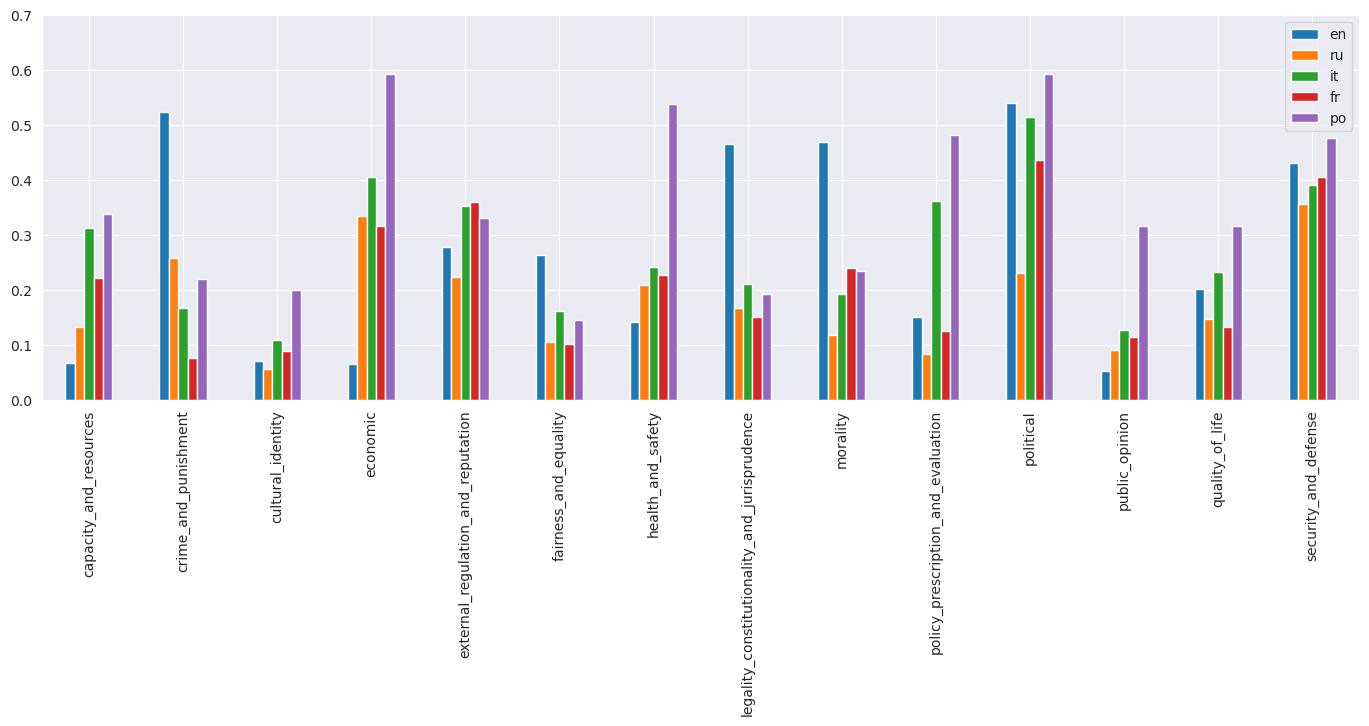

In [10]:
pd.DataFrame(freq_labels_dfs).sort_index().plot.bar(figsize=(17,5))
plt.xticks(rotation=90)
plt.ylim(0, 0.7)

The frequencies are a bit varied across languages, but we have the following common patterns:

 - Usually as prevalent classes for all three languages (>35%):
    - security_and_defense

 - Usually as low frequency classes ~10%
    - public_opinion
    - cultural_identity


## Co-occurrence of labels
### How correlated are the labels? How does it change by language?

In [11]:
def plot_correlation(corr_matrix: np.array, title: str, figsize=(11, 9)):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)
    plt.show()

Overall, we do not see strong correlations between labels in each of the three datasets. That is a good sign that labels are not ambiguous and are in fact distinct. They are all capped between -0.3 and 0.3. However, Polish does tend to have a stronger correlation, there are many more frames per document

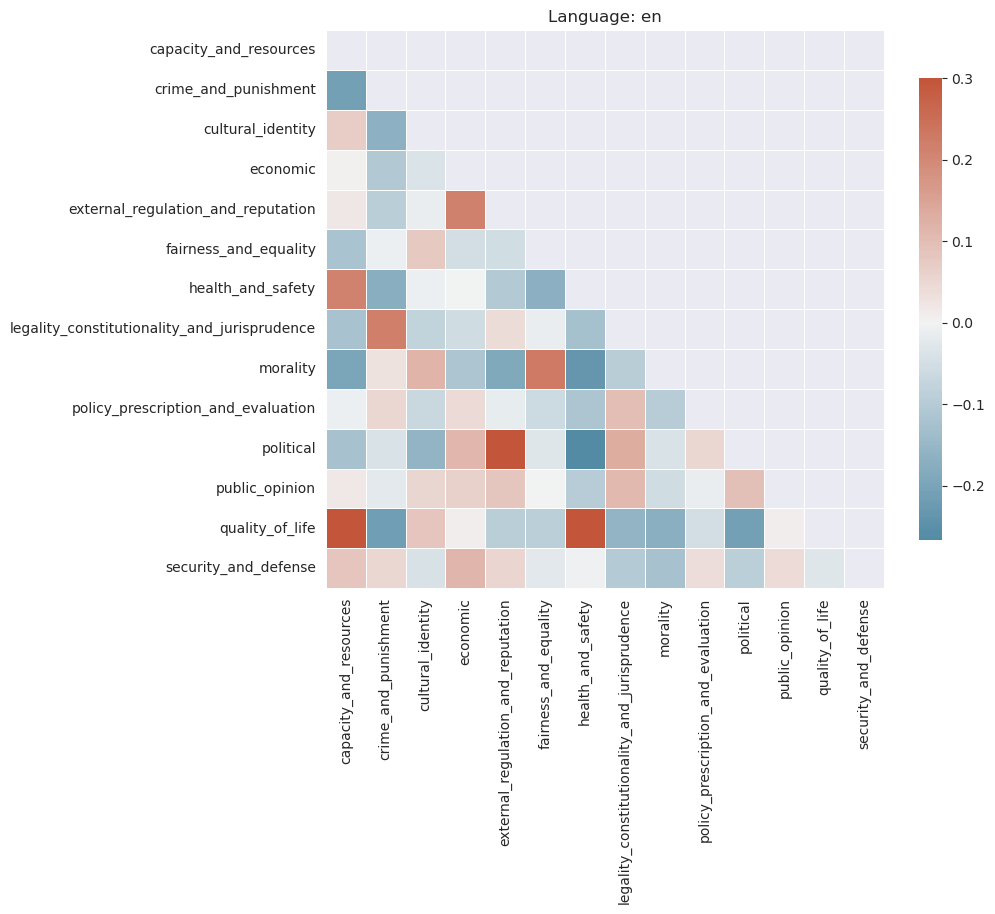

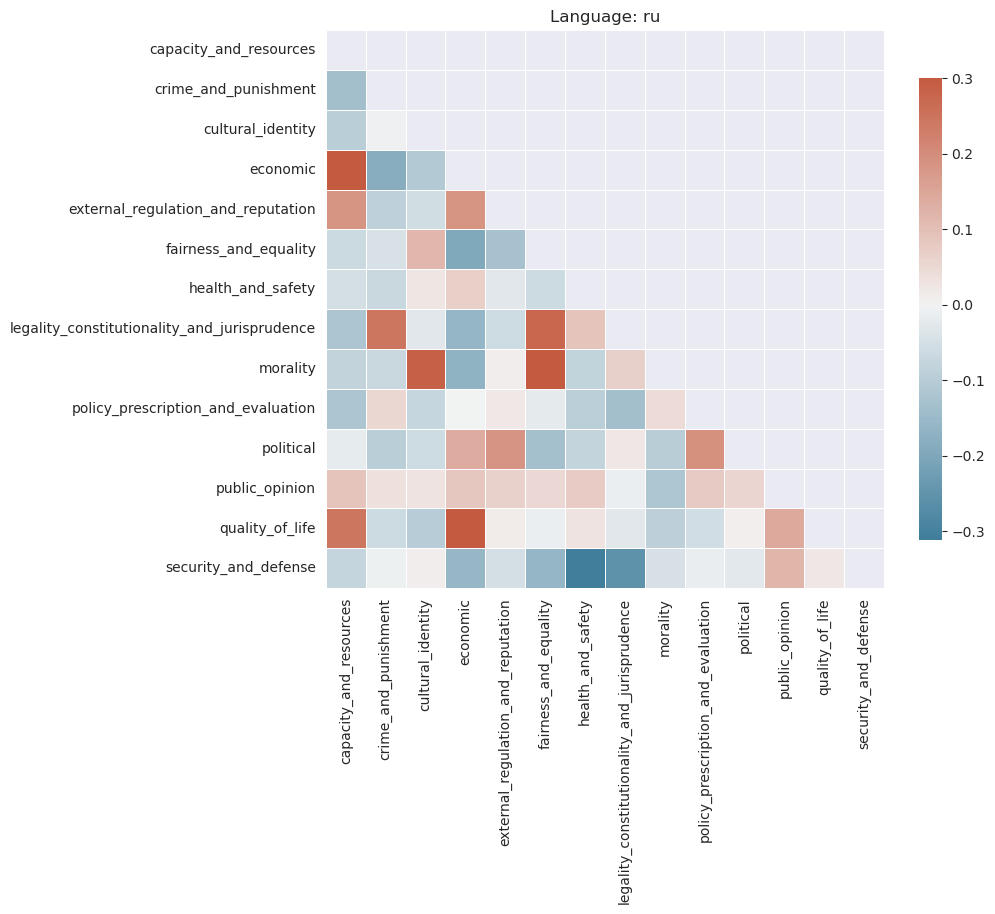

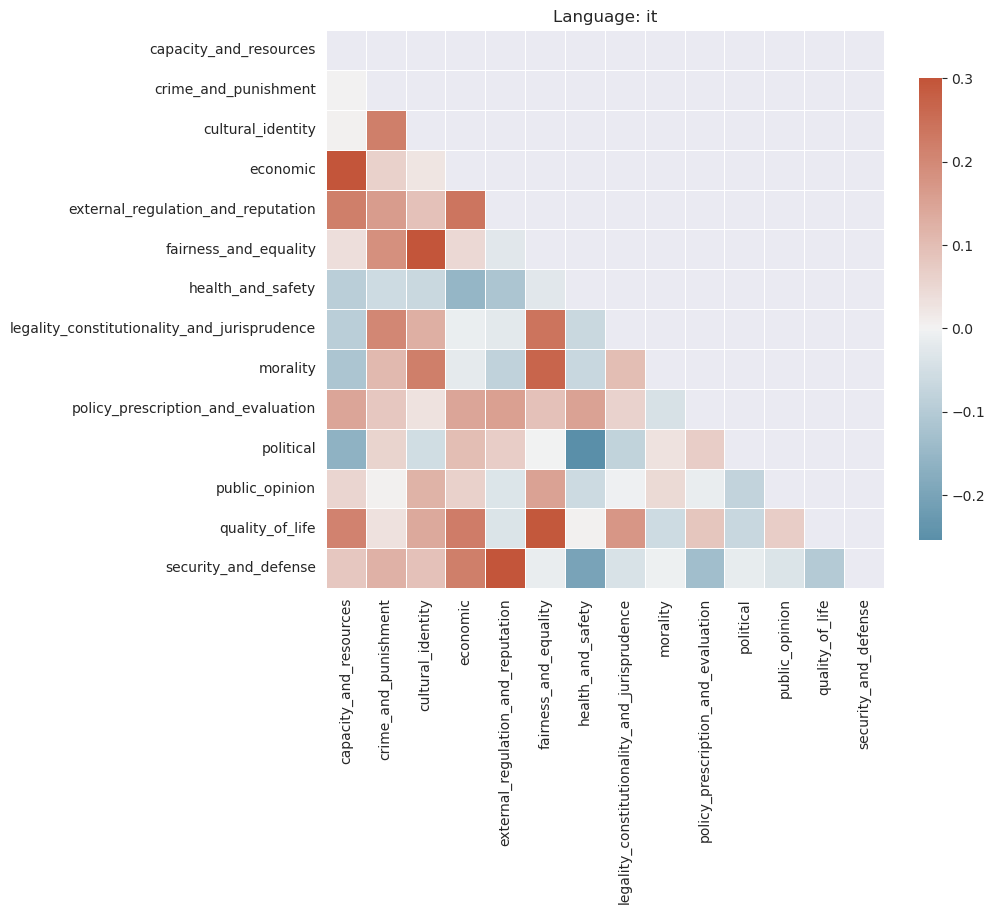

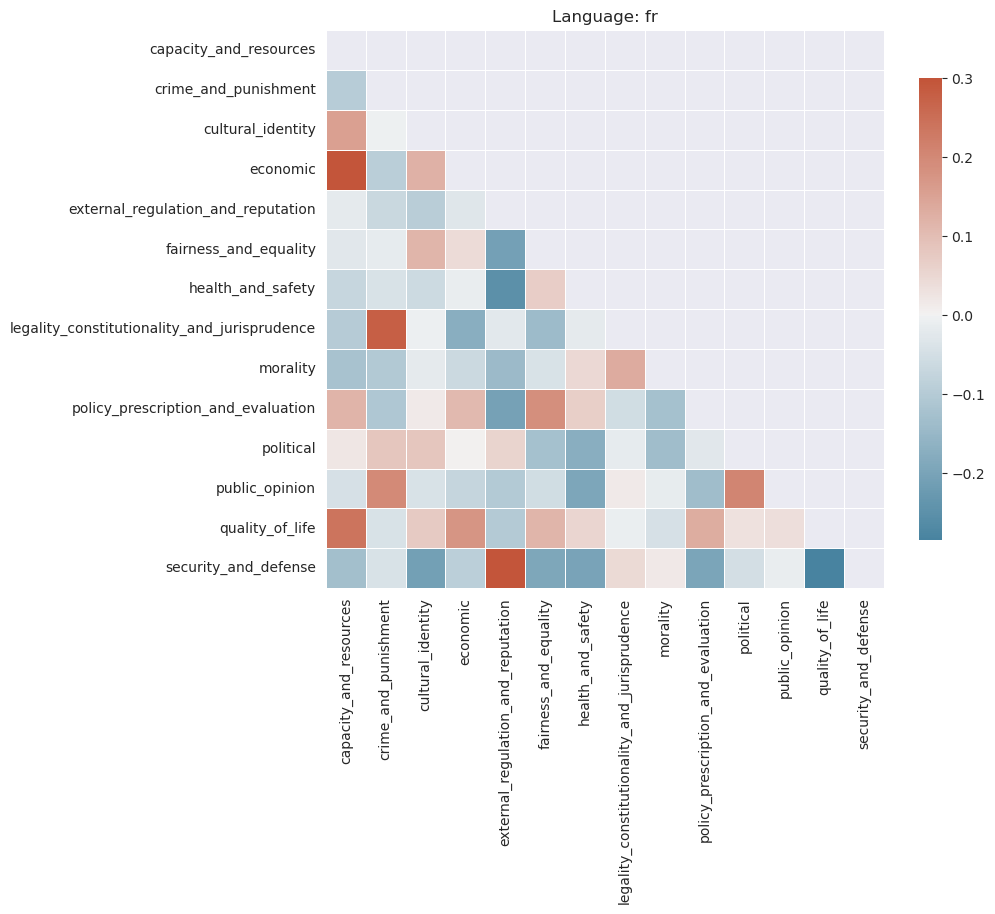

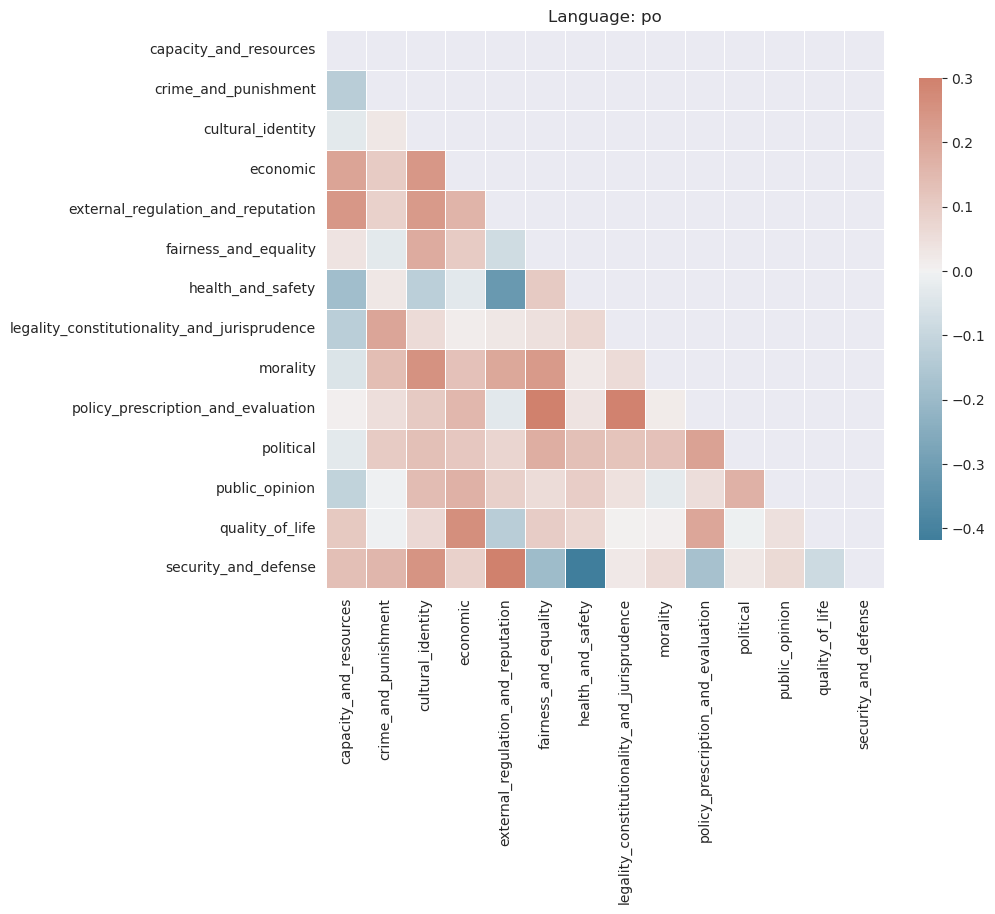

In [12]:
for language, labels_df in labels_dfs.items():
    plot_correlation(
        corr_matrix=labels_df.corr(method='spearman'), title=f'Language: {language}', figsize=(9, 12))


### Number of labels per document per language?

In [13]:
num_labels_df = {language: labels_df.sum(axis=1).rename(language).value_counts(normalize=True) for language, labels_df in labels_dfs.items()}
num_labels_df = pd.DataFrame(num_labels_df).fillna(0)

Text(0.5, 0, 'number of frames')

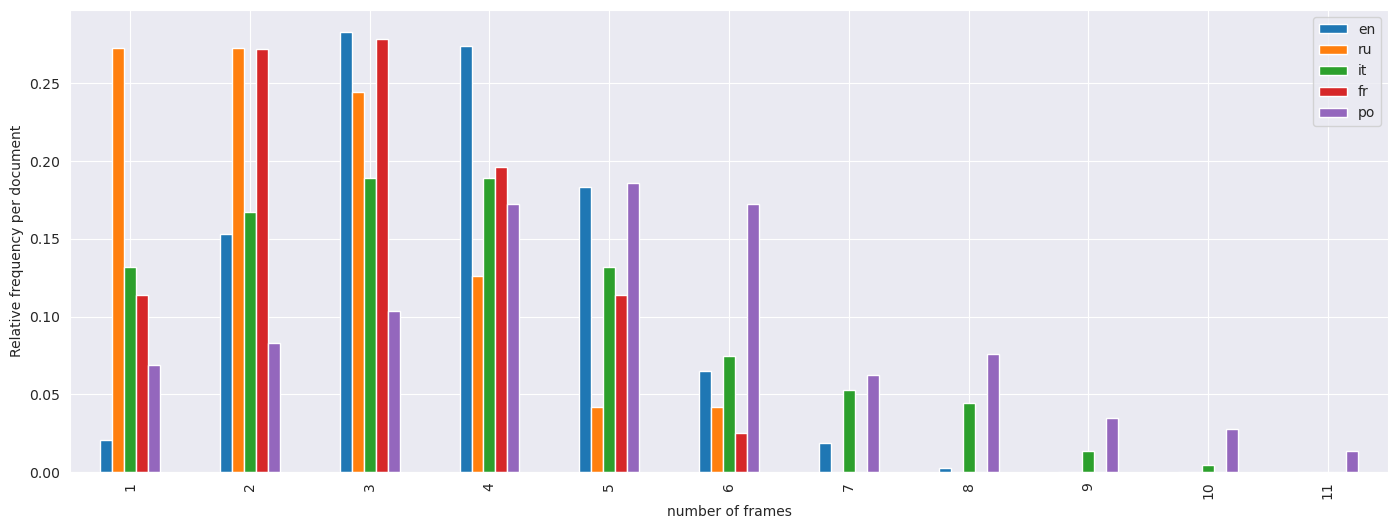

In [14]:
num_labels_df.plot.bar(figsize=(17 , 6))
plt.ylabel('Relative frequency per document')
plt.xlabel('number of frames')

Each one has a different skew and spread. Russian is skewed towards 1-3 frames, english 3-4, and italian 2-5, french 2-3, polish 5-6

## Check distribution of powerset over all datasets

We have $2^{14}$ possible combinations of labels, so 16,384 possible combinations. Let's check their distribution over all datasets

In [35]:
label_df = pd.concat([labels_df for labels_df in labels_dfs.values()],axis=0)

In [50]:
powerset_idx = lambda row: np.sum([2**(i) * row[column] for i, column in enumerate(label_df.columns)])

In [55]:
label_df['powerset_idx'] = label_df.apply(powerset_idx, axis=1)

In [77]:
powerset_count = label_df.powerset_idx.value_counts().reset_index(drop=True)

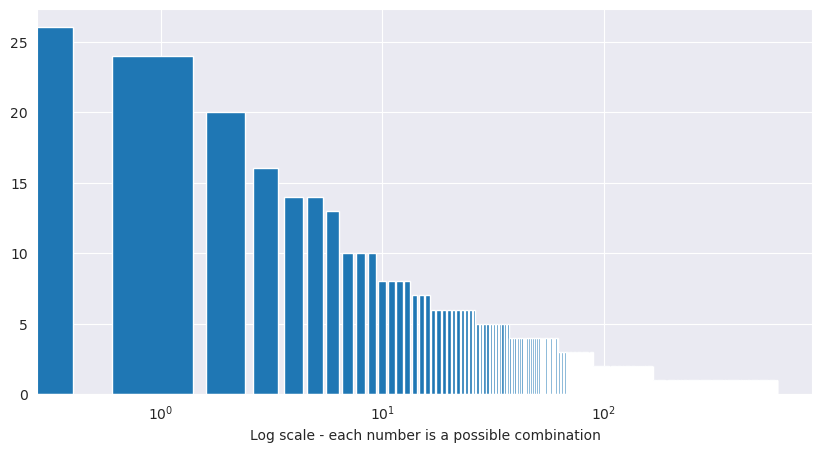

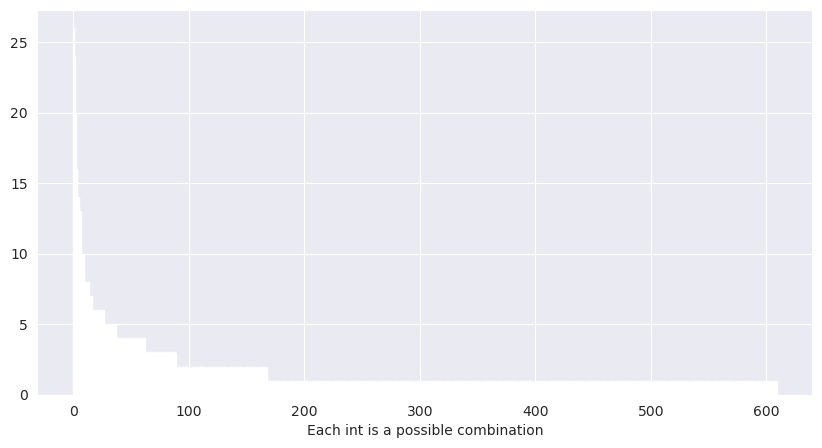

In [106]:
plt.figure(figsize=(10, 5))
plt.bar(x=powerset_count.index.to_list(), height=powerset_count)
plt.xscale('log')
plt.xlabel('Log scale - each number is a possible combination')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(x=powerset_count.index.to_list(), height=powerset_count, color='r')
plt.xlabel('Each int is a possible combination')
plt.show()

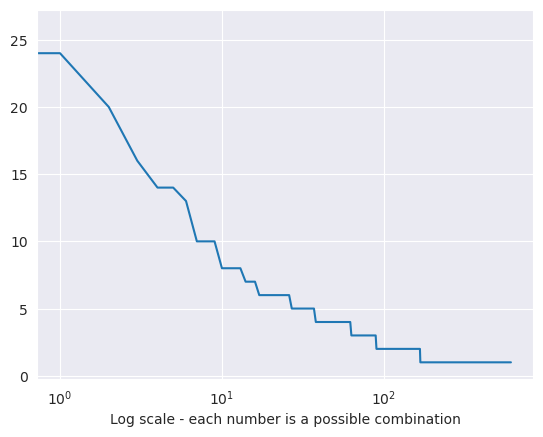

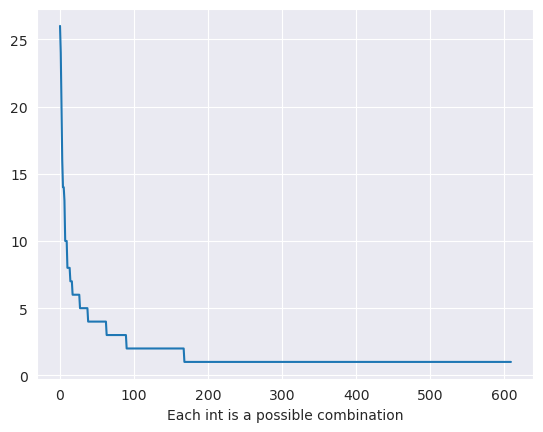

In [105]:
powerset_count.plot()
plt.xscale('log')
plt.xlabel('Log scale - each number is a possible combination')
plt.show()

powerset_count.plot()
plt.xlabel('Each int is a possible combination')
plt.show()

72% of the combinations we do have show only once.

In [109]:
(powerset_count == 1).sum()/powerset_count.shape[0]

0.7245901639344262

Out of all the combinations, we do not have 15,774 of them.

In [111]:
2**14 - powerset_count.shape[0]

15774

In [112]:
powerset_count.shape[0]

610

There is no chance to treat this as a powerset classification problem unless we break up the labelsets

## Analyze co-occurrence graph of labels

In [15]:
labels_dfs['en']

,capacity_and_resources,crime_and_punishment,cultural_identity,economic,external_regulation_and_reputation,fairness_and_equality,health_and_safety,legality_constitutionality_and_jurisprudence,morality,policy_prescription_and_evaluation,political,public_opinion,quality_of_life,security_and_defense
id,,,,,,,,,,,,,,
833042063,0,0,0,0,1,1,0,1,1,0,1,0,0,0
832959523,0,0,0,1,0,0,0,1,1,1,0,0,0,1
833039623,0,1,0,0,1,0,0,1,0,1,1,1,0,0
814777937,0,0,0,1,1,1,0,0,1,0,1,1,0,1
821744708,0,0,0,0,1,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832908978,0,1,0,1,1,0,0,1,0,0,1,0,0,0
832910505,0,1,0,0,0,0,0,0,1,1,1,0,1,0
832917532,0,1,0,0,1,0,0,1,0,0,1,0,0,0


## Top 10 tokens per label in english

### Measured by count


### Measured by TF-IDF